[View in Colaboratory](https://colab.research.google.com/github/ZackPashkin/Evaluating-a-Data-Model/blob/master/Evaluating_a_Data_Model.ipynb)

In [0]:
!pip install --upgrade google-cloud-bigquery

In [0]:
import matplotlib.pyplot as plt
from google.cloud import bigquery

client = bigquery.Client()

In [0]:
depdelayquery3 = """
SELECT
  *
FROM (
  SELECT
    DEP_DELAY,
    APPROX_QUANTILES(ARR_DELAY,
      101)[OFFSET(70)] AS arrival_delay,
    COUNT(ARR_DELAY) AS numflights
  FROM
    `flights.tzcorr` f
  JOIN
    `flights.trainday` t
  ON
    f.FL_DATE = t.FL_DATE
  WHERE
    t.is_train_day = 'True'
  GROUP BY
    DEP_DELAY )
WHERE
  numflights > 370
ORDER BY
  DEP_DELAY
"""

/usr/local/envs/py2env/lib/python2.7/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/usr/local/envs/py2env/lib/python2.7/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


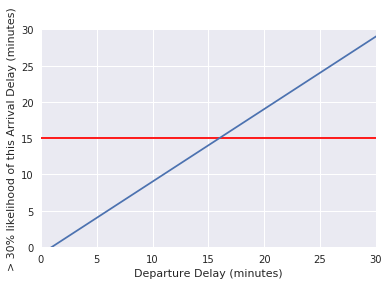

In [0]:
depdelay = client.query(depdelayquery3).to_dataframe()
plt.axhline(y=15, color='r')
ax = plt.axes()
depdelay.plot(kind='line', x='DEP_DELAY', y='arrival_delay',
              ax=ax, ylim=(0, 30), xlim=(0, 30), legend=False)
ax.set_xlabel('Departure Delay (minutes)')
ax.set_ylabel('> 30% likelihood of this Arrival Delay (minutes)');

create a query string that captures the contingency table that allows  to score the effectiveness of the model:

In [0]:
evalquery = """
SELECT
  SUM(IF(DEP_DELAY < 16
      AND arr_delay < 15, 1, 0)) AS correct_nocancel,
  SUM(IF(DEP_DELAY < 16
      AND arr_delay >= 15, 1, 0)) AS wrong_nocancel,
  SUM(IF(DEP_DELAY >= 16
      AND arr_delay < 15, 1, 0)) AS wrong_cancel,
  SUM(IF(DEP_DELAY >= 16
      AND arr_delay >= 15, 1, 0)) AS correct_cancel
FROM (
  SELECT
    DEP_DELAY,
    ARR_DELAY
  FROM
    `flights.tzcorr` f
  JOIN
    `flights.trainday` t
  ON
    f.FL_DATE = t.FL_DATE
  WHERE
    t.is_train_day = 'False' )
"""
eval = client.query(evalquery).to_dataframe()
eval

,correct_nocancel,wrong_nocancel,wrong_cancel,correct_cancel
0,1259740,66081,52827,217669


In [0]:
print eval['correct_nocancel'] / (eval['correct_nocancel'] + \
eval['wrong_nocancel'])
print eval['correct_cancel'] / (eval['correct_cancel'] + \
eval['wrong_cancel'])

0    0.950158
dtype: float64
0    0.804703
dtype: float64


re-evaluate the contingency table just for values at the decision boundary, i.e. only for flights where DEP_DELAY is 15 minutes, and flights are not cancelled or 16 minutes and flights are cancelled.

In [0]:
evalquery2="""
SELECT
  SUM(IF(DEP_DELAY = 15
      AND arr_delay < 15, 1, 0)) AS correct_nocancel,
  SUM(IF(DEP_DELAY = 15
      AND arr_delay >= 15, 1, 0)) AS wrong_nocancel,
  SUM(IF(DEP_DELAY = 16
      AND arr_delay < 15, 1, 0)) AS wrong_cancel,
  SUM(IF(DEP_DELAY = 16
      AND arr_delay >= 15, 1, 0)) AS correct_cancel
FROM (
  SELECT
    DEP_DELAY,
    ARR_DELAY
  FROM
    `flights.tzcorr` f
  JOIN
    `flights.trainday` t
  ON
    f.FL_DATE = t.FL_DATE
  WHERE
    t.is_train_day = 'False' )
"""
eval = client.query(evalquery2).to_dataframe()
eval

,correct_nocancel,wrong_nocancel,wrong_cancel,correct_cancel
0,7684,2935,6787,2942


display the ratio of correct to incorrect calls.



In [0]:
print eval['correct_nocancel'] / (eval['correct_nocancel'] + \
eval['wrong_nocancel'])
print eval['correct_cancel'] / (eval['correct_cancel'] + \
eval['wrong_cancel'])

0    0.723609
dtype: float64
0    0.302395
dtype: float64
